In [5]:
import numpy as np
from __future__ import division

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size = (N, M))

In [6]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [7]:
%%cython -a

from __future__ import division

import numpy as np
cimport numpy as np
cimport cython
from numpy cimport abs

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

cdef random_spin_field(int N, int M):
    return np.random.choice([-1, 1], size = (N, M))
    
@cython.boundscheck(False)
@cython.wraparound(False)
cdef cy_ising_step(int[:, :] field, float beta):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n, m
    for n in range(N):
        for m in range(M):
            cy_metropolis_update(field, n, m, beta)
    return field


@cython.boundscheck(False)
@cython.wraparound(False)
cdef cy_metropolis_update(int[:, :] field, int n, int m, float beta):
    
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef float total = 0
    
    total = field[(n + 1)%N, m] + field[(n - 1)%N, m] + field[n, (m + 1)%M] + field[n, (m - 1)%M]
    cdef float E1 = 2 * field[n, m] * total
            
    if E1 <= 0:
        field[n, m] *= -1
    elif rand() < RAND_MAX * exp(-beta * E1):
        field[n, m] *= -1

@cython.boundscheck(False)
@cython.wraparound(False)
cdef cy_magnetization(int[:, :] field):
    cdef int mag = np.sum(field)
    return mag

@cython.boundscheck(False)
@cython.wraparound(False)
cdef cy_energy(int[:, :] field):
    cdef int energy = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef i, j
    for i in range(N):
        for j in range(M):
            s = field[i,j]
            nn = field[(i + 1)%N, j] + field[(i - 1)%N, j] + field[i, (j + 1)%M] + field[i, (j - 1)%M]
            energy += -nn*s
    return energy / 4.0


def main():
    ## PARAMETERS
    cdef int N = 64             #size of lattice
    cdef int temp_points = 200  #number of temperature points
    cdef np.float64_t[:] T = np.linspace(1.53, 3.28, temp_points, dtype=np.float64)
    cdef np.float64_t[:] E = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] M = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] C = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] X = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] absM = np.zeros(temp_points, dtype=np.float64)

    cdef int eqsteps = 15000
    cdef int mcsteps = 5000
    cdef float mc = 5000
    cdef float n1 = 1.0/(mc*N*N)
    cdef float n2 = 1.0/(mc*mc*N*N)    

    #step analysis
    cdef np.int32_t[:] MS = np.arange(eqsteps+mcsteps,dtype=np.int32)
    cdef float avg = 1.0/(N*N)
    cdef np.float64_t[:, :] mrange = np.zeros((len(T), eqsteps+mcsteps),dtype=np.float64)


    import time
    import sys
    cdef int a = 0
    cdef int h = 0
    cdef int p = 0
    cdef float m = 0.0
    cdef float e1 = 0.0
    cdef float absm1 = 0.0
    cdef float e2 = 0.0
    cdef float m2 = 0.0
    cdef int[:,:] field = random_spin_field(N, N)
    cdef float b1 = 1.0 / T[p]
    cdef float b2 = b1 * b1;
    cdef int i = 0
    start_time = time.clock()
    
    for p in range(len(T)):
        e1 = absm1 = e2 = m2 = 0.0
        m = 0.0
        field = random_spin_field(N, N)
        b1 = 1.0 / T[p] 
        b2 = b1 * b1;
        for i in range(eqsteps):
            cy_ising_step(field, b1)
            mag = cy_magnetization(field)
            m = m + mag
            mrange[h][i]=m*avg*(1/(i+1))

        for i in range(mcsteps):
            cy_ising_step(field, b1)
            ene = cy_energy(field)
            mag = cy_magnetization(field)

            e1 = e1 + ene
            absm1 = absm1 + np.abs(mag)
            m = m + mag
            m2 = m2 + mag*mag
            e2 = e2 + ene*ene
            mrange[h][i + eqsteps]=m*avg*(1/(i+eqsteps))
                
        h += 1

        a += 1
        print a 
        
        E[p] = n1*e1
        absM[p] = n1*absm1
        C[p] = (n1*e2 - n2*e1*e1)*b2
        X[p] = (n1*m2 - n2*absm1*absm1)*b1
    
    cdef float seconds = time.clock() - start_time
    cdef float minutes = 0
    cdef float hours = 0
    cdef str x = ''
    
    if seconds >= 60:
        minutes = seconds / 60.0
        seconds = seconds - minutes * 60
    if minutes >= 60:
        hours = minutes / 60.0
        minutes = minutes - hours * 60

    if hours > 0:
        x = 'Calculation took ' + str('%.0f' % hours) + ' hours, ' + str('%.0f' % minutes) + ' minutes and ' + str( '%.0f' % seconds) + " seconds."
    elif hours == 0 and minutes > 0:
        x = 'Calculation took ' + str('%.0f' % minutes) + ' minutes and ' + str( '%.0f' % seconds) + " seconds."
    else:
        x = 'Calculation took ' + str('%.0f' % seconds) + " seconds."
        
    return x, np.asarray(T), np.asarray(E), np.asarray(absM), np.asarray(C), np.asarray(X), N, np.asarray(MS), np.asarray(mrange), eqsteps, mcsteps
    

def display(x, T, E, absM, C, X, N, MS, mrange, eqsteps, mcsteps):
    import matplotlib.pyplot as plt

    f = plt.figure(figsize=(36, 20)); # plot the calculated values    

    plt.title('-'+np.str(N)+'x'+np.str(N)+' lattice-' + ' ' + x,fontsize=50)
    plt.axis('off')

    sp =  f.add_subplot(2, 2, 1 );
    plt.scatter(T, E, s=70, marker='o', color='IndianRed')
    plt.xlabel("Temperature (T)", fontsize=40);
    plt.ylabel("Energy ", fontsize=40);     plt.axis('tight');

    sp =  f.add_subplot(2, 2, 2 );
    plt.scatter(T, np.abs(absM), s=70, marker='o', color='RoyalBlue')
    #plt.vlines(2.27,0,1, lw = 2)
    plt.xticks(fontsize = 40);
    plt.yticks(fontsize = 40);
    plt.xlabel("Temperature (T)", fontsize=40); 
    plt.ylabel("Magnetization ", fontsize=40);   plt.axis('tight');
    
    sp =  f.add_subplot(2, 2, 3 );
    plt.scatter(T, C, s=70, marker='o', color='IndianRed')
    plt.xlabel("Temperature (T)", fontsize=40);  
    plt.ylabel("Specific Heat ", fontsize=40);   plt.axis('tight');   

    sp =  f.add_subplot(2, 2, 4 );
    plt.scatter(T, X, s=70, marker='o', color='RoyalBlue')
    plt.xlabel("Temperature (T)", fontsize=40); 
    plt.ylabel("Susceptibility", fontsize=40);   plt.axis('tight');

    import math
    import colorsys
    r = len(T)
    HSV_tuples = [(q*2.8/r, 1, .8) for q in range(r)]
    RGB_tuples = map(lambda q: colorsys.hsv_to_rgb(*q), HSV_tuples)
  
    g = plt.figure(figsize=(36, 20));
    
    ct = 2/math.atanh(math.sqrt(1/2))
    for q in range(0,len(RGB_tuples),10): 
        if T[q] > ct:  
            plt.plot(MS, mrange[q], color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),lw = 2);
            plt.hlines(0, 0, eqsteps+mcsteps,
                       color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),
                       label = str('%.2f' % (T[q]/2.27)) + r'$T_C$', lw = 4)
        else:
            if mrange[q][eqsteps] < 0:
                plt.plot(MS, mrange[q], color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),lw = 2);
                plt.hlines(-math.pow(np.abs(1-math.pow(math.sinh(2.0/T[q]),-4)),1/8), 0, eqsteps+mcsteps,
                           color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),
                           label = str('%.2f' % (T[q]/2.27)) + r'$T_C$', lw = 4)
            else:
                plt.plot(MS, mrange[q], color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),lw = 2);
                plt.hlines(math.pow(np.abs(1-math.pow(math.sinh(2.0/T[q]),-4)),1/8), 0, eqsteps+mcsteps,
                           color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),
                           label = str('%.2f' % (T[q]/2.27)) + r'$T_C$', lw = 4)


    plt.xticks(fontsize = 40);
    plt.yticks(fontsize = 40);
    plt.legend(bbox_to_anchor=(1,1), loc=1,fontsize = 30);
    plt.axis([-10,eqsteps+mcsteps,np.min(mrange),1]);
    plt.xlabel("MC steps per lattice site", fontsize=30); 
    plt.ylabel("Magnetization ", fontsize=30);
    plt.title(str(N)+'x'+str(N)+' lattice', fontsize = 50)

C:\Users\Andrew\Anaconda2\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Andrew\.ipython\cython\_cython_magic_2faf5d67e94325e44b07e8625d750e2d.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [234]:
values = main()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


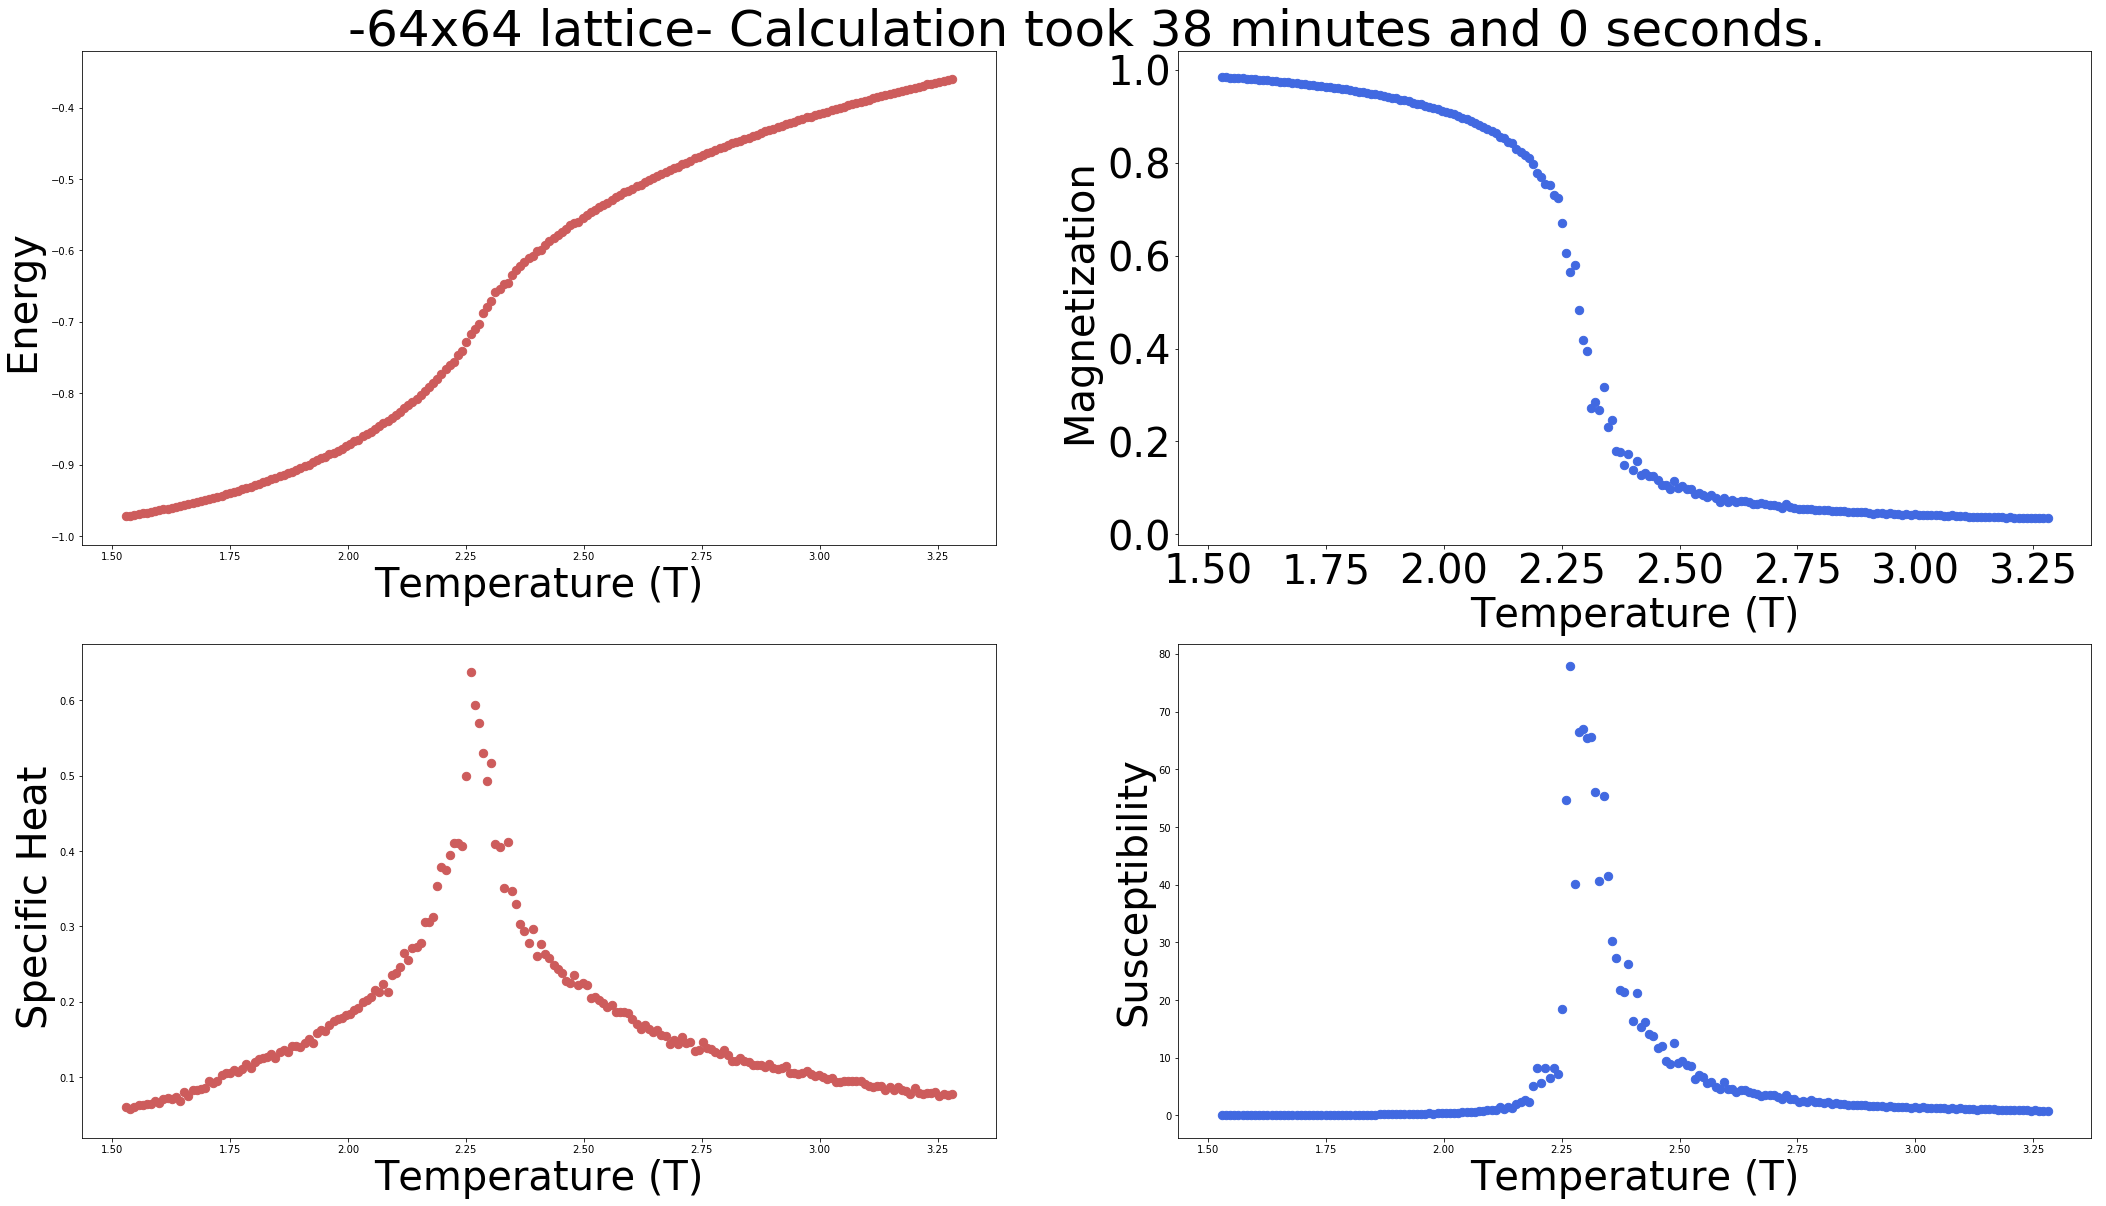

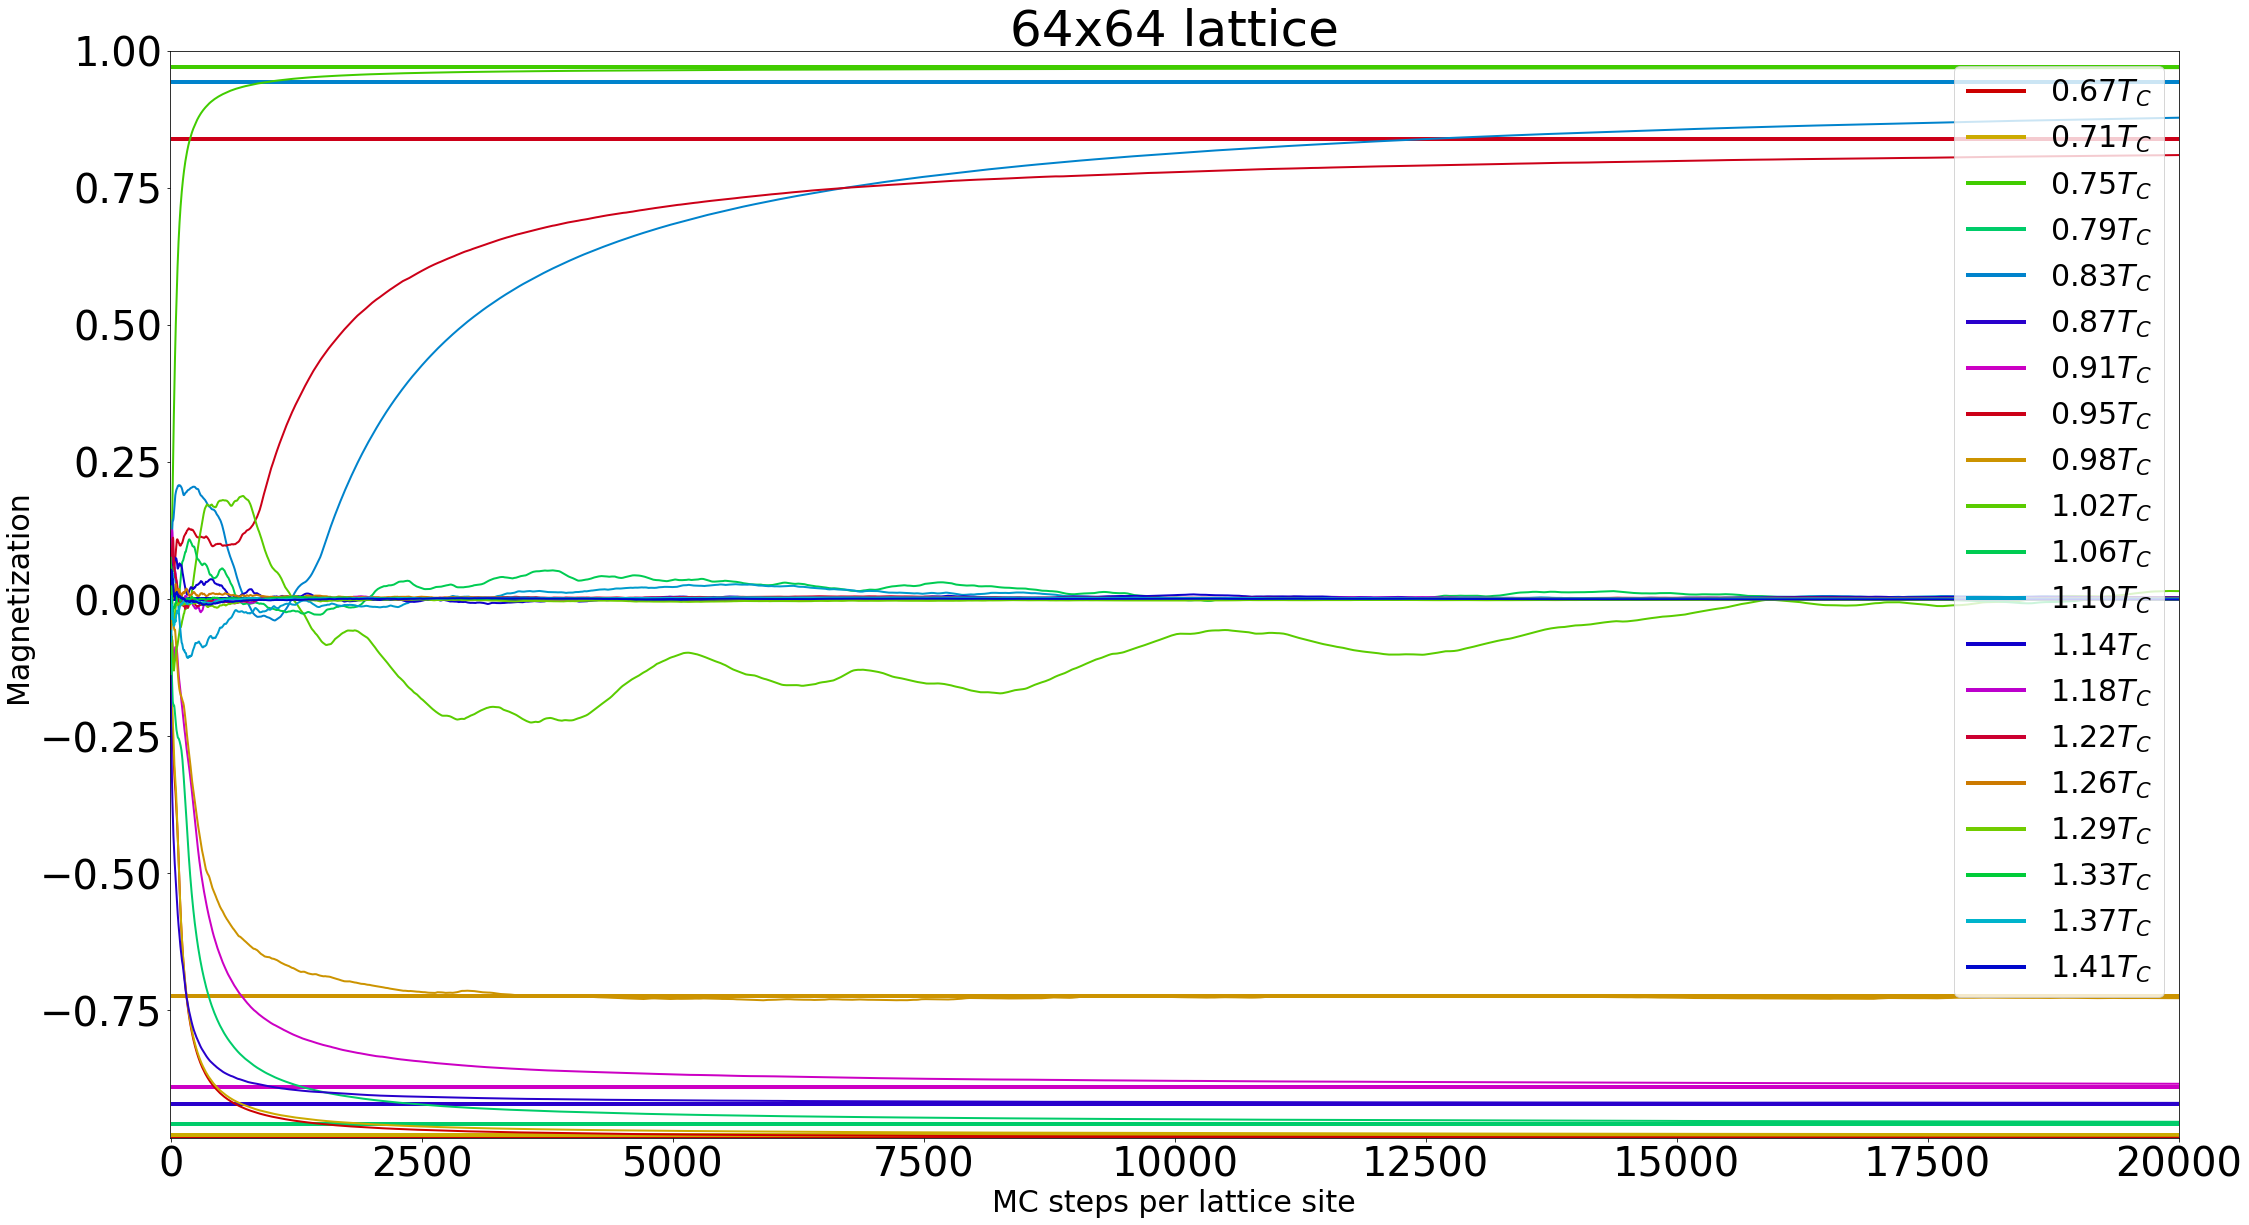

In [235]:
x=values[0]
T=values[1]
E = values[2]
absM=values[3]
C = values[4]
X = values[5]
N=values[6]
MS=values[7]
mrange=values[8]
eqsteps=values[9]
mcsteps=values[10]
display(x, T, E, absM, C, X, N, MS, mrange, eqsteps, mcsteps)

NameError: name 'epsilon_0' is not defined